In [1]:
from tqdm import tqdm
from glob import glob
import tifffile
import numpy as np
import os
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, split_train_test, split_train_crops, get_data_properties
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_many_crops
import json
from matplotlib.colors import ListedColormap

### Download Data

In [2]:
data_dir = '../../../data'
project_name = 'bbbc010-2012'

Ideally, <b>*.tif</b>-type images and the corresponding masks should be respectively present under <b>images</b> and <b>masks</b>, under directories <b>train</b>, <b>val</b> and <b>test</b>, which can be present at any location on your workstation, pointed to by the variable <i>data_dir</i>. (In order to prepare such instance masks, one could use the Fiji plugin <b>Labkit</b> as detailed <b>[here](https://github.com/juglab/EmbedSeg/wiki/Use-Labkit-to-prepare-instance-masks)</b>). The following would be the desired structure as to how data should be present. 

<img src="https://raw.githubusercontent.com/juglab/EmbedSeg/v0.2.4/directory_pngs/png/01_dir_structure.png" width="100"/>

If you already have your data available in the above style, please skip to the <b><a href="#center">third</a></b> section of this notebook, where you specify the kind of center to which constitutive pixels of an object should embed. 
Since for the <b> bbbc010-2012</b> we do not have the data in this format yet, we firstly download the data from an external url in the following cells, next we split this data to create our `train`, `val` and `test` directories. 
     

The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`. The following structure is generated after executing the `extract_data`, `split_train_test` and `split_train_val` methods below:

<img src="https://raw.githubusercontent.com/juglab/EmbedSeg/v0.2.4/directory_pngs/png/02_bbbc010-2012.png" width="400"/>

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/bbbc010-2012.zip',
    data_dir = data_dir,
    project_name = project_name,
)

Zip file was downloaded and extracted before!


### Split Data into `train`, `val` \& `test`

Since the `train`-`test` data partition doesn't exist by itself in the original data, we can execute the following cell to reserve some data as evaluation or test data. Here, we reserve 50 % of the available data for evaluation, as is usually done in literature, with regards to the `bbbc010-2012` dataset.

In [4]:
split_train_test(
    data_dir = data_dir,
    project_name = project_name, 
    train_test_name = 'train',
    subset = 0.5)

Train-Test Images/Masks already available at ../../../data/bbbc010-2012/download


For this dataset, instead of reserving a small fraction of the train dataset for validation at this stage, we first crop the images and masks in the subsequent code cells, and <b><a href= "split_val">later</a></b> reserve some of the generated crops for the purposes of validation. We notice that such a strategy allows better results for `bbbc010-2012` during prediction (because of a small dataset size). Running the next cell simply copies the train and test images and masks to the `$data_dir/$project_name/train/.` and `$data_dir/$project_name/test/.` respectively.

In [5]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.0)

Train-Val-Test Images/Masks copied to ../../../data/bbbc010-2012


### Specify desired centre location for spatial embedding of pixels
<a id='center'></a>

Interior pixels of an object instance can either be embedded at the `medoid`, the `approximate-medoid` or the `centroid`. 

In [6]:
center = 'medoid'  # 'medoid', 'approximate-medoid', 'centroid'
try:
    assert center in {'medoid', 'approximate-medoid', 'centroid'}
    print("Spatial Embedding Location chosen as : {}".format(center))
except AssertionError as e:
    e.args += ('Please specify center as one of : {"medoid", "approximate-medoid", "centroid"}', 42)
    raise



Spatial Embedding Location chosen as : medoid


### Calculate some dataset specific properties

In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. <br>
We will also specify some properties, for example,  
* set `data_properties_dir['one_hot'] = True` in case the instances are encoded in a one-hot style. 
* set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and 
    `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

Lastly, we will save the dictionary `data_properties_dir` in a json file, which we will access in the `02-train` and `03-predict` notebooks.

In [7]:
one_hot = True
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train'], 
                                          test_name=['test'], mode='2d', one_hot=one_hot)

data_properties_dir['data_type']='16-bit'

with open('data_properties.json', 'w') as outfile:
    json.dump(data_properties_dir, outfile)
    print("Dataset properties of the `{}` dataset is saved to `data_properties.json`".format(project_name))

 10%|████▍                                       | 5/50 [00:00<00:01, 40.96it/s]

Foreground weight of the `bbbc010-2012` dataset set equal to 10.000


  8%|███▌                                        | 4/50 [00:00<00:01, 38.71it/s]

Minimum object size of the `bbbc010-2012` dataset is equal to 491
Average object size of the `bbbc010-2012` dataset along `x` is equal to 72.765
Std. dev object size of the `bbbc010-2012` dataset along `x` is equal to 35.170
Average object size of the `bbbc010-2012` dataset along `y` is equal to 75.520
Std. dev object size of the `bbbc010-2012` dataset along `y` is equal to 33.638


  8%|███▌                                        | 4/50 [00:00<00:01, 32.18it/s]

Maximum evaluation image size of the `bbbc010-2012` dataset set equal to (1024, 1024)


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 36.24it/s]

Dataset properties of the `bbbc010-2012` dataset is saved to `data_properties.json`


### Specify cropping configuration parameters

Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook). Here, `data_subset` defines the directory which is processed. Since we only have `train` images and masks at `$data_dir/$project_name/train`, hence we set `data_subset=train`.

Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y\}$ and `n_sigma` equals `5` by default.

Please feel free to reduce the parameter `n_sigma` to be equal to `3-4` in case of lower GPU memory.  

In [8]:
n_sigma = 5

In [9]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [10]:
crops_dir = './crops'
data_subset = 'train' 
crop_size = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x']))
print("Crop size in x and y will be set equal to {}".format(crop_size))

Crop size in x and y will be set equal to 248


### Generate Crops



<div class="alert alert-block alert-warning"> 
    The cropped images and masks are saved at the same-location as the example notebooks. <br>
    Generating the crops might take a little while!
</div>

While cropping images, we normalize them by following any one of three strategies: 

(i) `min-max-percentile` (default) 
(ii) `mean-std` 
(iii) `absolute` 

In [17]:
norm = 'mean-std'
try:
    assert norm in {'min-max-percentile', 'mean-std', 'absolute'}
    print("Normalization chosen as : {}".format(norm))
except AssertionError as e:
    e.args += ('Please specify norm as one of : {"min-max-percentile", "mean-std", "absolute"}', 42)
    raise

Normalization chosen as : mean-std


In [18]:
image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
for i in tqdm(np.arange(len(image_names))):
    if one_hot:
        process_one_hot(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, crop_size, center, one_hot = one_hot, norm=norm, data_type = data_properties_dir['data_type'])
    else:
        process(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, crop_size, center, one_hot=one_hot, norm=norm, data_type = data_properties_dir['data_type'])
print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

100%|███████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]

Cropping of images, instances and centre_images for data_subset = `train` done!


### Save `norm` in `normalization.json` file 

In [19]:
normalization = {}
normalization['data_type']=data_properties_dir['data_type']
normalization['norm']=norm
with open('normalization.json', 'w') as outfile:
    json.dump(normalization, outfile)
    print("Normalization properties of the `{}` dataset is saved to `normalization.json`".format(project_name))

Normalization properties of the `bbbc010-2012` dataset is saved to `normalization.json`


### Move a fraction of the generated crops for validation purposes

Here we reserve a small fraction (15 \% by default) of the images, masks and center-images crops for the purpose of validation. 
<a id="later_val">

In [20]:
split_train_crops(project_name = project_name, center = center, crops_dir = crops_dir, subset = 0.15)

Created new directory : ./crops/bbbc010-2012/val/images/
Created new directory : ./crops/bbbc010-2012/val/masks/
Created new directory : ./crops/bbbc010-2012/val/center-medoid/
Val Images/Masks/Center-medoid-image crops saved at ./crops/bbbc010-2012/val


### Visualize cropped images, corresponding ground truth masks and object center images 

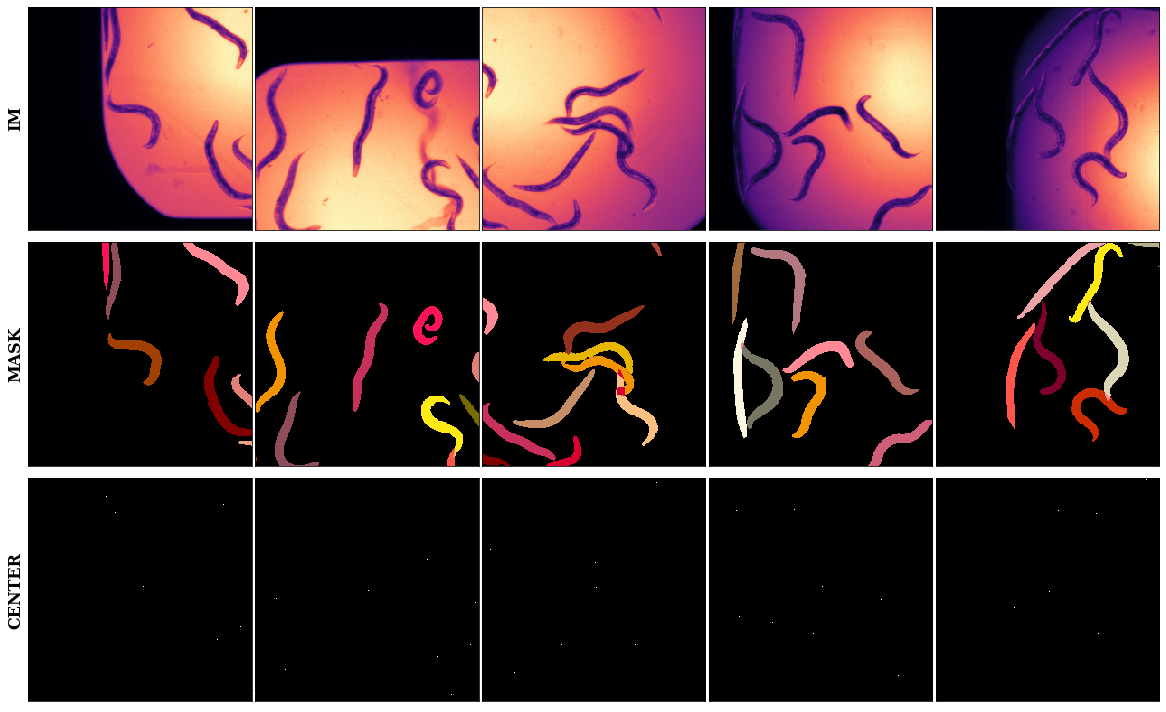

In [21]:
new_cmap = np.load('../../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_crops(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, n_images=5, new_cmp=new_cmap, one_hot=one_hot)